# Sentiment Analysis: Comprehensive Machine Learning Pipeline

This notebook implements a complete sentiment analysis pipeline for classifying text as **positive**, **negative**, or **neutral**.

## Pipeline Stages:
1. Data Loading and Exploration
2. Exploratory Data Analysis (EDA)
3. Text Preprocessing
4. Feature Engineering
5. Model Training (Multiple Models)
6. Model Evaluation and Comparison
7. Model Deployment Preparation

## 1. Setup and Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import os
import re
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Machine Learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create directories if they don't exist
os.makedirs('charts', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

print("✓ All libraries imported successfully!")
print(f"Working Directory: {os.getcwd()}")

✓ All libraries imported successfully!
Working Directory: /Users/ismatsamadov/sentiment_analysis


In [2]:
# Download required NLTK data
nltk_packages = ['stopwords', 'punkt', 'punkt_tab', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']
for package in nltk_packages:
    try:
        nltk.download(package, quiet=True)
    except:
        pass
print("✓ NLTK packages downloaded!")

✓ NLTK packages downloaded!


## 2. Data Loading and Initial Exploration

In [3]:
# Load training and test data
print("Loading datasets...")
df_train = pd.read_csv('dataset/train.csv', encoding='latin-1')
df_test = pd.read_csv('dataset/test.csv', encoding='latin-1')

print(f"\nTraining set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

# Display first few rows
print("\n" + "="*80)
print("TRAINING DATA SAMPLE")
print("="*80)
display(df_train.head())

# Save output
with open('outputs/01_data_overview.txt', 'w') as f:
    f.write(f"Training set shape: {df_train.shape}\n")
    f.write(f"Test set shape: {df_test.shape}\n")
    f.write(f"\nColumns: {df_train.columns.tolist()}\n")
    f.write(f"\nData types:\n{df_train.dtypes}\n")

print("\n✓ Data loaded successfully!")

Loading datasets...

Training set shape: (27481, 10)
Test set shape: (4815, 9)

TRAINING DATA SAMPLE


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26



✓ Data loaded successfully!


In [4]:
# Data info
print("DATASET INFORMATION")
print("="*80)
print(f"\nColumns: {df_train.columns.tolist()}")
print(f"\nData Types:")
print(df_train.dtypes)
print(f"\nMissing Values:")
print(df_train.isnull().sum())
print(f"\nBasic Statistics:")
print(df_train.describe())

DATASET INFORMATION

Columns: ['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']

Data Types:
textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km²)     float64
Density (P/Km²)       int64
dtype: object

Missing Values:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

Basic Statistics:
       Population -2020  Land Area (Km²)  Density (P/Km²)
count      2.748100e+04     2.748100e+04     27481.000000
mean       4.018497e+07     6.621730e+05       357.686583
std        1.504946e+08     1.807425e+06      2013.750702
min        8

## 3. Exploratory Data Analysis (EDA)

SENTIMENT DISTRIBUTION
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

Percentages:
sentiment
neutral     40.457043
positive    31.228849
negative    28.314108
Name: proportion, dtype: float64


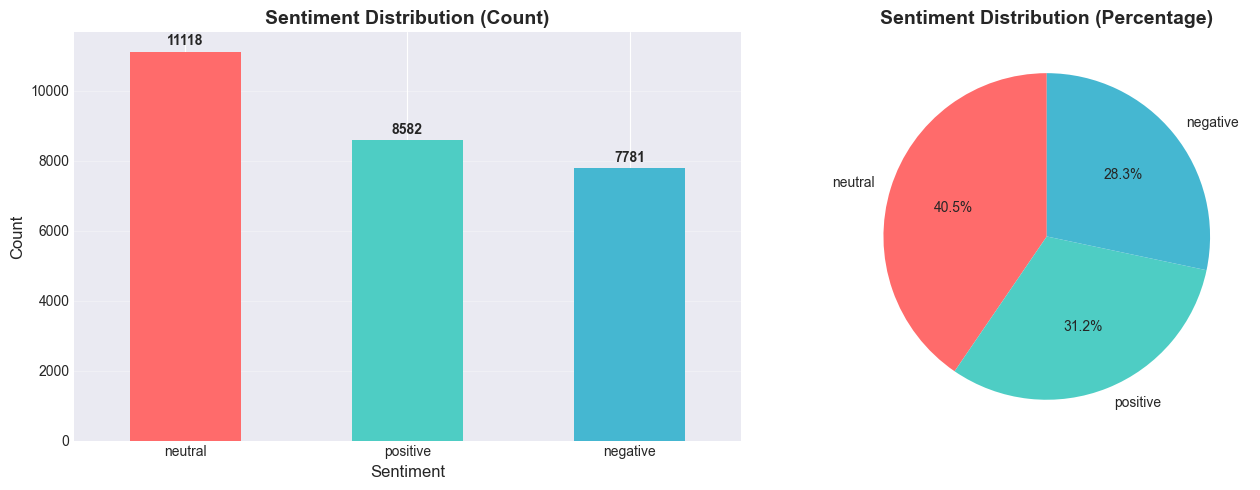


✓ Chart saved: charts/01_sentiment_distribution.png


In [5]:
# Sentiment distribution
print("SENTIMENT DISTRIBUTION")
print("="*80)
sentiment_counts = df_train['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nPercentages:")
print(df_train['sentiment'].value_counts(normalize=True) * 100)

# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
sentiment_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
sentiment_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('charts/01_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved: charts/01_sentiment_distribution.png")

TEXT LENGTH STATISTICS

Character Count Statistics:
             count       mean        std  min   25%   50%   75%    max
sentiment                                                             
negative    7781.0  70.509318  35.176069  5.0  42.0  66.0  98.0  147.0
neutral    11118.0  65.233855  36.437009  3.0  35.0  59.0  94.0  159.0
positive    8582.0  70.437427  34.662597  5.0  42.0  67.0  98.0  141.0

Word Count Statistics:
             count       mean       std  min  25%   50%   75%   max
sentiment                                                          
negative    7781.0  13.473204  6.874375  1.0  8.0  13.0  19.0  32.0
neutral    11118.0  12.342867  7.057233  1.0  6.0  11.0  18.0  33.0
positive    8582.0  13.109881  6.746352  1.0  8.0  12.0  18.0  33.0


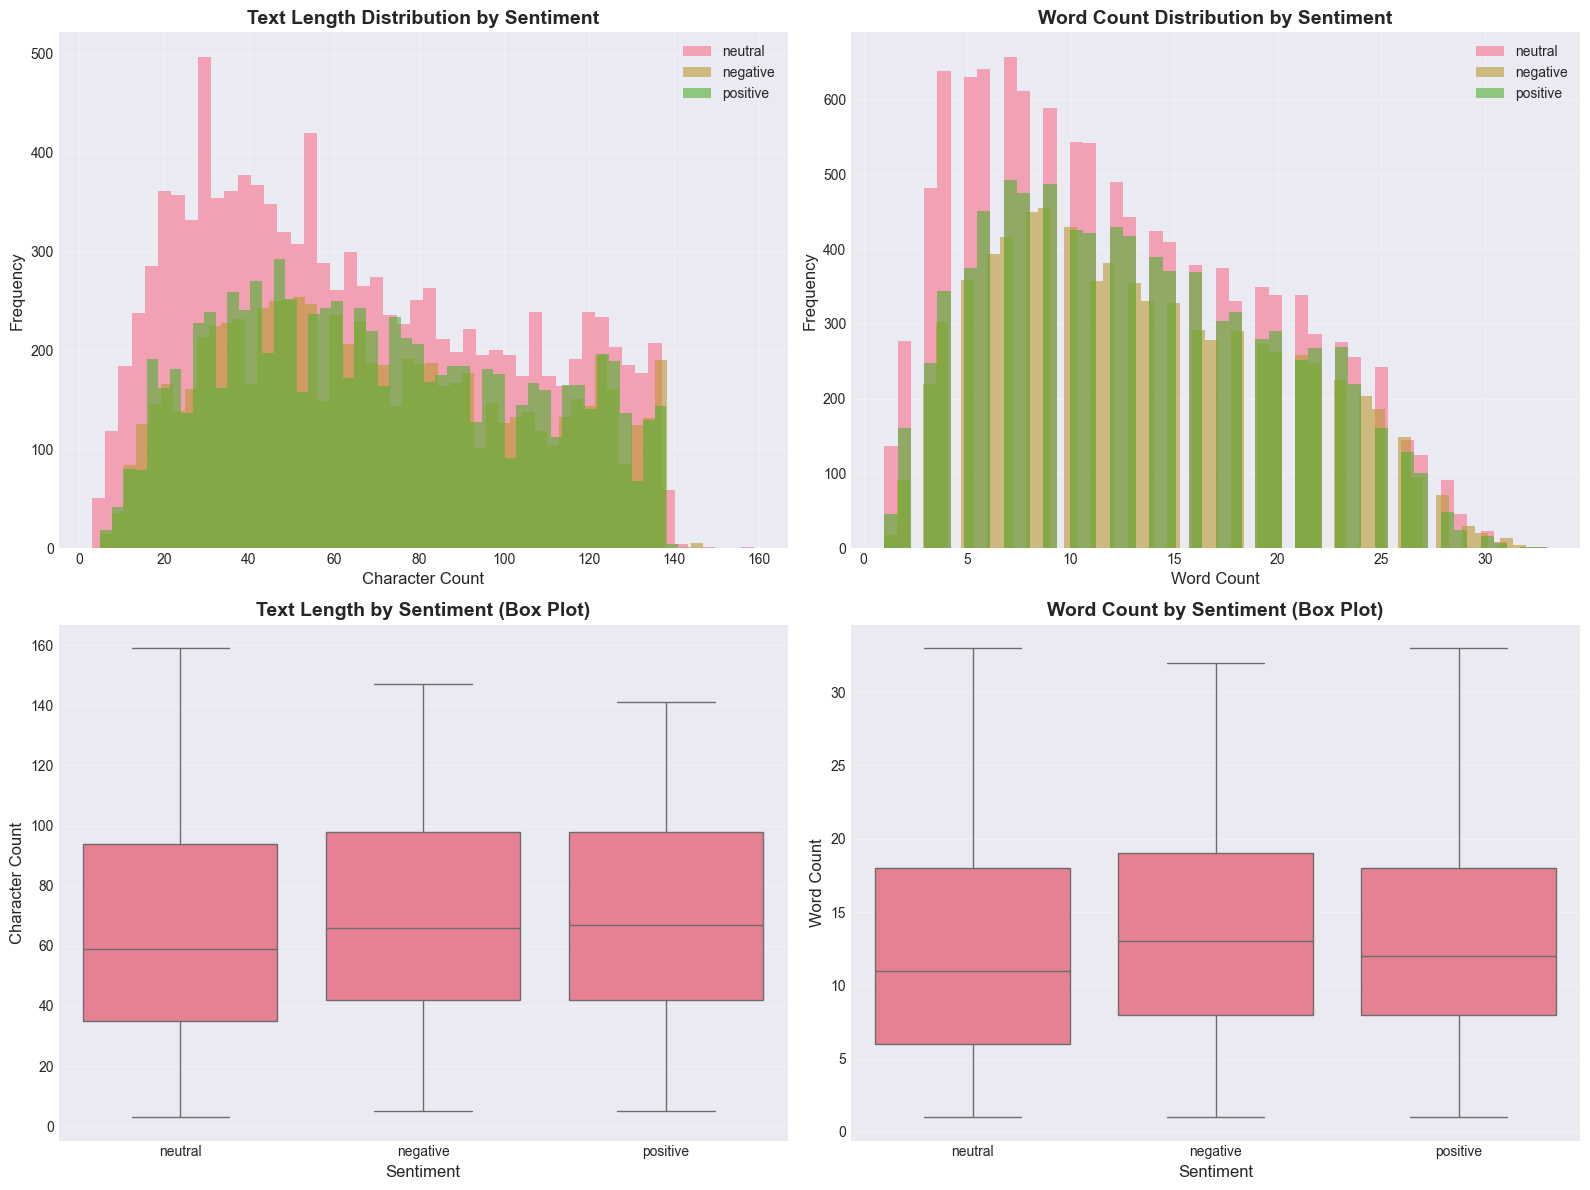


✓ Chart saved: charts/02_text_length_analysis.png


In [6]:
# Text length analysis
df_train['text_length'] = df_train['text'].astype(str).apply(len)
df_train['word_count'] = df_train['text'].astype(str).apply(lambda x: len(x.split()))

print("TEXT LENGTH STATISTICS")
print("="*80)
print("\nCharacter Count Statistics:")
print(df_train.groupby('sentiment')['text_length'].describe())
print("\nWord Count Statistics:")
print(df_train.groupby('sentiment')['word_count'].describe())

# Visualize text length distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length by sentiment
for sentiment in df_train['sentiment'].unique():
    data = df_train[df_train['sentiment'] == sentiment]['text_length']
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=sentiment)
axes[0, 0].set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Character Count', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Word count by sentiment
for sentiment in df_train['sentiment'].unique():
    data = df_train[df_train['sentiment'] == sentiment]['word_count']
    axes[0, 1].hist(data, bins=50, alpha=0.6, label=sentiment)
axes[0, 1].set_title('Word Count Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Word Count', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot - character length (using seaborn for better control)
sns.boxplot(data=df_train, x='sentiment', y='text_length', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sentiment', fontsize=12)
axes[1, 0].set_ylabel('Character Count', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plot - word count (using seaborn for better control)
sns.boxplot(data=df_train, x='sentiment', y='word_count', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment', fontsize=12)
axes[1, 1].set_ylabel('Word Count', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('charts/02_text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved: charts/02_text_length_analysis.png")

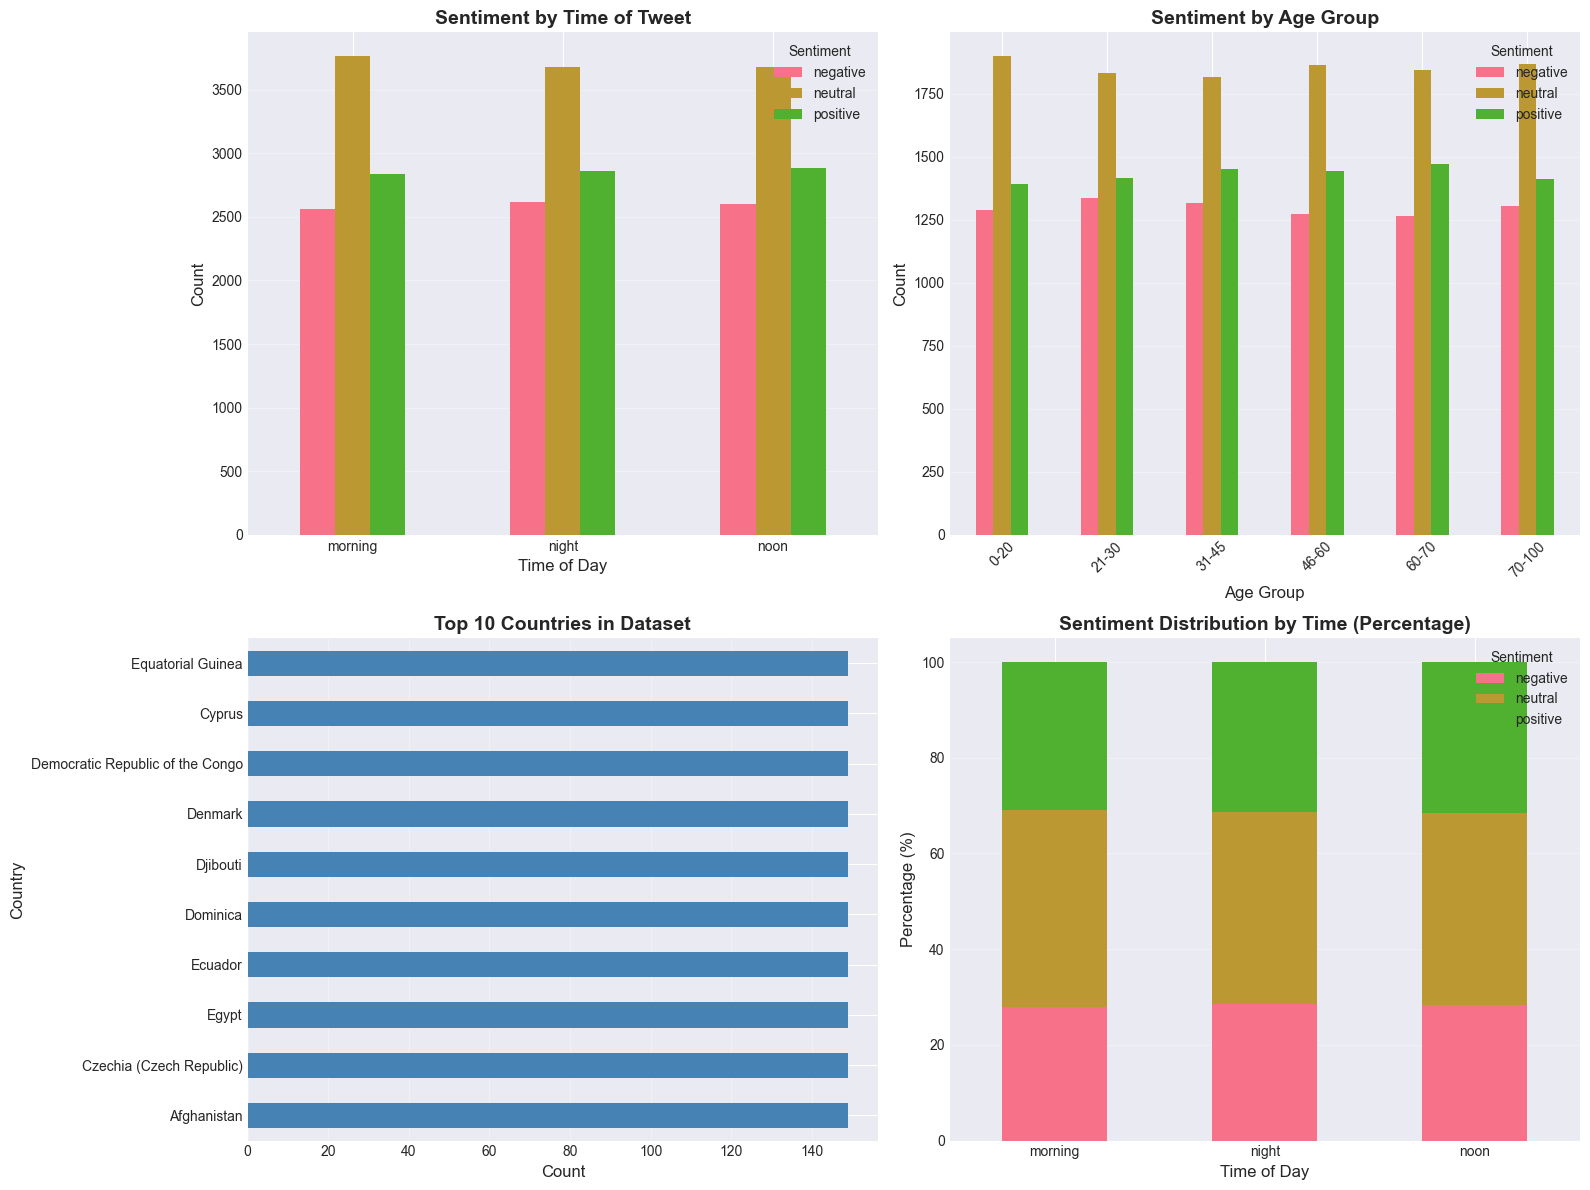


✓ Chart saved: charts/03_metadata_analysis.png


In [7]:
# Additional metadata analysis (Time, Age, Country)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time of Tweet distribution
if 'Time of Tweet' in df_train.columns:
    time_sentiment = pd.crosstab(df_train['Time of Tweet'], df_train['sentiment'])
    time_sentiment.plot(kind='bar', ax=axes[0, 0], stacked=False)
    axes[0, 0].set_title('Sentiment by Time of Tweet', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Time of Day', fontsize=12)
    axes[0, 0].set_ylabel('Count', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=0)
    axes[0, 0].legend(title='Sentiment')
    axes[0, 0].grid(axis='y', alpha=0.3)

# Age distribution
if 'Age of User' in df_train.columns:
    age_sentiment = pd.crosstab(df_train['Age of User'], df_train['sentiment'])
    age_sentiment.plot(kind='bar', ax=axes[0, 1], stacked=False)
    axes[0, 1].set_title('Sentiment by Age Group', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Age Group', fontsize=12)
    axes[0, 1].set_ylabel('Count', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(title='Sentiment')
    axes[0, 1].grid(axis='y', alpha=0.3)

# Top 10 countries
if 'Country' in df_train.columns:
    top_countries = df_train['Country'].value_counts().head(10)
    top_countries.plot(kind='barh', ax=axes[1, 0], color='steelblue')
    axes[1, 0].set_title('Top 10 Countries in Dataset', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Count', fontsize=12)
    axes[1, 0].set_ylabel('Country', fontsize=12)
    axes[1, 0].grid(axis='x', alpha=0.3)

# Sentiment percentage by time
if 'Time of Tweet' in df_train.columns:
    time_sentiment_pct = pd.crosstab(df_train['Time of Tweet'], df_train['sentiment'], normalize='index') * 100
    time_sentiment_pct.plot(kind='bar', ax=axes[1, 1], stacked=True)
    axes[1, 1].set_title('Sentiment Distribution by Time (Percentage)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Time of Day', fontsize=12)
    axes[1, 1].set_ylabel('Percentage (%)', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].legend(title='Sentiment')
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('charts/03_metadata_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved: charts/03_metadata_analysis.png")

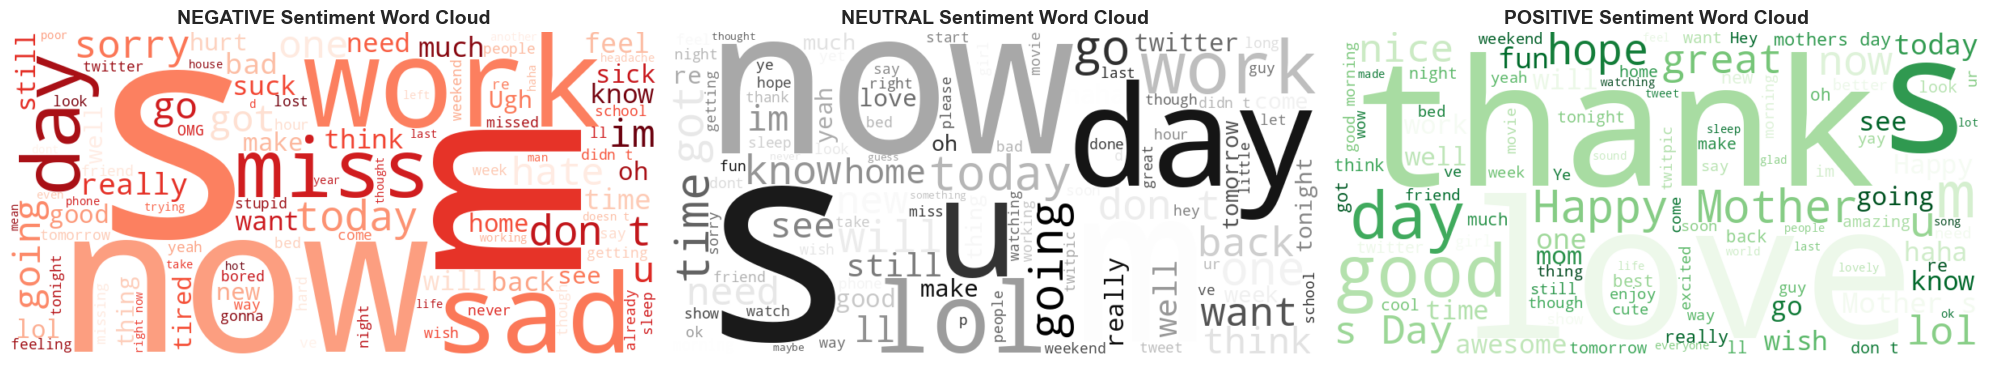


✓ Chart saved: charts/04_wordclouds.png


In [8]:
# Word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['negative', 'neutral', 'positive']
colors = ['Reds', 'Greys', 'Greens']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    text = ' '.join(df_train[df_train['sentiment'] == sentiment]['text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          colormap=color, max_words=100).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.upper()} Sentiment Word Cloud', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('charts/04_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved: charts/04_wordclouds.png")

In [9]:
# Save EDA summary
eda_summary = {
    'total_samples': len(df_train),
    'sentiment_distribution': df_train['sentiment'].value_counts().to_dict(),
    'avg_text_length': df_train['text_length'].mean(),
    'avg_word_count': df_train['word_count'].mean(),
    'text_length_by_sentiment': df_train.groupby('sentiment')['text_length'].mean().to_dict(),
    'word_count_by_sentiment': df_train.groupby('sentiment')['word_count'].mean().to_dict()
}

with open('outputs/02_eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=4)

print("✓ EDA summary saved: outputs/02_eda_summary.json")

✓ EDA summary saved: outputs/02_eda_summary.json


## 4. Text Preprocessing

In [10]:
# Text preprocessing function
def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove mentions (@username)
    4. Remove hashtags
    5. Remove special characters and digits
    6. Remove extra whitespace
    7. Tokenize
    8. Remove stopwords
    9. Lemmatize
    """
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

print("✓ Text preprocessing function defined")

# Test the function
sample_text = df_train['text'].iloc[0]
print(f"\nOriginal text: {sample_text}")
print(f"Processed text: {preprocess_text(sample_text)}")

✓ Text preprocessing function defined

Original text:  I`d have responded, if I were going
Processed text: responded going


In [11]:
# Apply preprocessing to train and test data
print("Preprocessing training data...")
df_train['clean_text'] = df_train['text'].apply(preprocess_text)

print("Preprocessing test data...")
df_test['clean_text'] = df_test['text'].apply(preprocess_text)

# Remove empty texts
df_train = df_train[df_train['clean_text'].str.len() > 0]
df_test = df_test[df_test['clean_text'].str.len() > 0]

# Reset index to align with TF-IDF matrix
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"\n✓ Preprocessing complete!")
print(f"Training samples after cleaning: {len(df_train)}")
print(f"Test samples after cleaning: {len(df_test)}")

# Show examples
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES")
print("="*80)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df_train['text'].iloc[i]}")
    print(f"Cleaned:  {df_train['clean_text'].iloc[i]}")
    print(f"Sentiment: {df_train['sentiment'].iloc[i]}")

# Save preprocessing examples
with open('outputs/03_preprocessing_examples.txt', 'w', encoding='utf-8') as f:
    for i in range(10):
        f.write(f"\nExample {i+1}:\n")
        f.write(f"Original: {df_train['text'].iloc[i]}\n")
        f.write(f"Cleaned:  {df_train['clean_text'].iloc[i]}\n")
        f.write(f"Sentiment: {df_train['sentiment'].iloc[i]}\n")
        f.write("-"*80 + "\n")

print("\n✓ Preprocessing examples saved: outputs/03_preprocessing_examples.txt")

Preprocessing training data...
Preprocessing test data...

✓ Preprocessing complete!
Training samples after cleaning: 27384
Test samples after cleaning: 4799

PREPROCESSING EXAMPLES

Example 1:
Original:  I`d have responded, if I were going
Cleaned:  responded going
Sentiment: neutral

Example 2:
Original:  Sooo SAD I will miss you here in San Diego!!!
Cleaned:  sooo sad miss san diego
Sentiment: negative

Example 3:
Original: my boss is bullying me...
Cleaned:  bos bullying
Sentiment: negative

✓ Preprocessing examples saved: outputs/03_preprocessing_examples.txt


## 5. Feature Engineering

In [12]:
# Prepare features and labels
# First, ensure no missing values in sentiment column
df_train = df_train.dropna(subset=['sentiment'])
df_test = df_test.dropna(subset=['sentiment'])

X_train = df_train['clean_text']
y_train = df_train['sentiment']
X_test = df_test['clean_text']
y_test = df_test['sentiment']

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts())

Training set size: 27384
Test set size: 3518

Label distribution in training set:
sentiment
neutral     11033
positive     8578
negative     7773
Name: count, dtype: int64


In [13]:
# TF-IDF Vectorization
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=2,
    max_df=0.9
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✓ TF-IDF features created!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Save vectorizer
with open('artifacts/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("\n✓ Vectorizer saved: artifacts/tfidf_vectorizer.pkl")

Creating TF-IDF features...

✓ TF-IDF features created!
Feature matrix shape: (27384, 5000)
Number of features: 5000

✓ Vectorizer saved: artifacts/tfidf_vectorizer.pkl


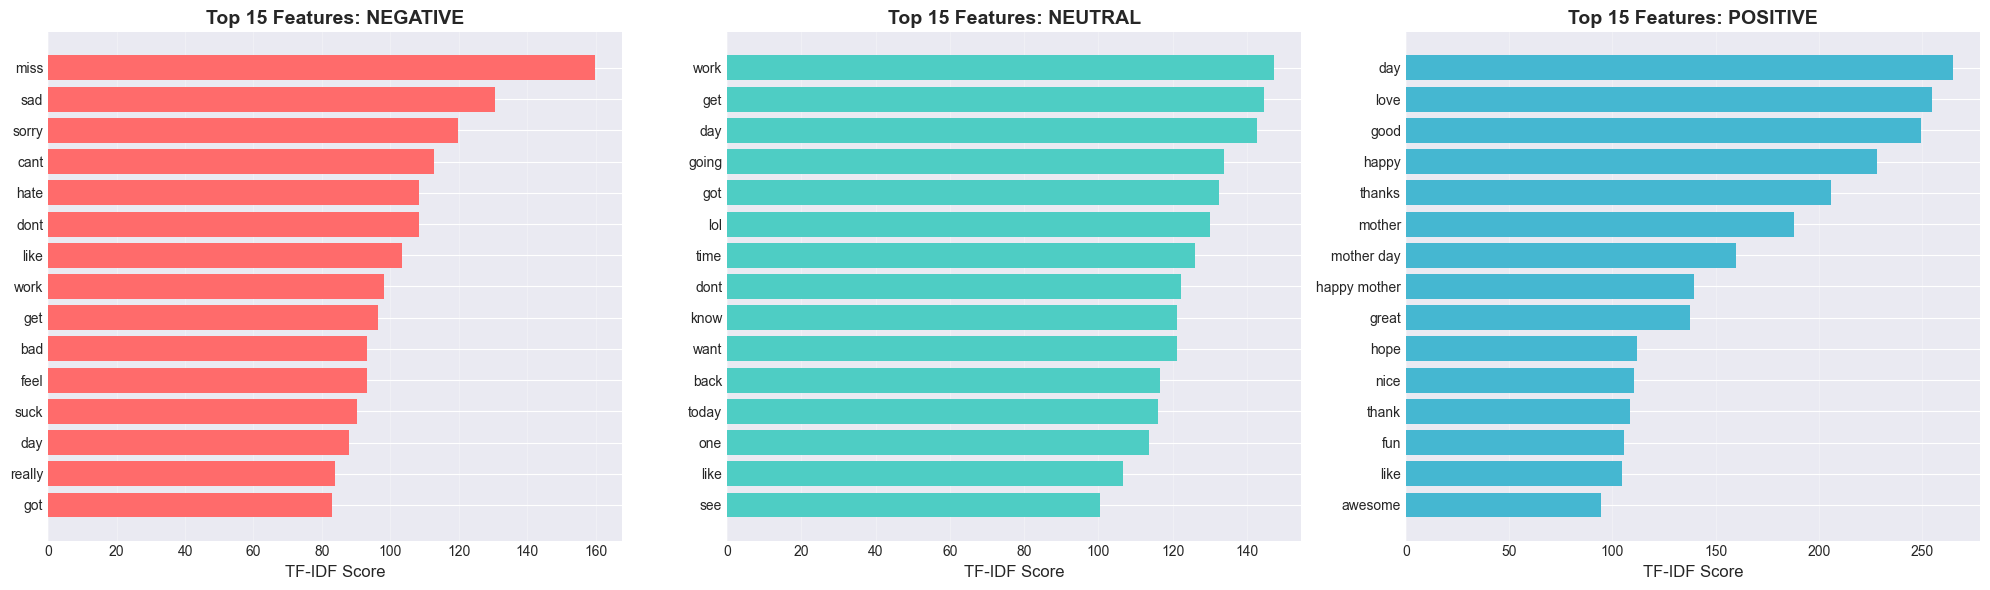

✓ Chart saved: charts/05_top_features.png


In [14]:
# Top features by sentiment
feature_names = tfidf_vectorizer.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiments = ['negative', 'neutral', 'positive']

for idx, sentiment in enumerate(sentiments):
    # Get boolean mask for this sentiment (convert to numpy array)
    sentiment_mask = (y_train == sentiment).values
    
    # Sum TF-IDF scores for this sentiment
    tfidf_sum = np.asarray(X_train_tfidf[sentiment_mask].sum(axis=0)).flatten()
    
    # Get top 15 features
    top_indices = tfidf_sum.argsort()[-15:][::-1]
    top_features = [(feature_names[i], tfidf_sum[i]) for i in top_indices]
    
    # Plot
    features, scores = zip(*top_features)
    axes[idx].barh(range(len(features)), scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][idx])
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features)
    axes[idx].set_title(f'Top 15 Features: {sentiment.upper()}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('TF-IDF Score', fontsize=12)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('charts/05_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: charts/05_top_features.png")

## 6. Model Training

In [15]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")

Models initialized:
  - Naive Bayes
  - Logistic Regression
  - Linear SVM
  - Random Forest
  - Gradient Boosting


In [16]:
# Train models and collect results
results = {}
trained_models = {}

print("Training models...\n")
print("="*80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_tfidf, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)
    
    # Evaluate
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Store results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'y_pred_test': y_pred_test,
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True)
    }
    
    trained_models[name] = model
    
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy:  {test_accuracy:.4f}")
    
print("\n" + "="*80)
print("✓ All models trained successfully!")

Training models...


Training Naive Bayes...
  Train Accuracy: 0.7289
  Test Accuracy:  0.6475

Training Logistic Regression...
  Train Accuracy: 0.7749
  Test Accuracy:  0.6964

Training Linear SVM...
  Train Accuracy: 0.8000
  Test Accuracy:  0.6774

Training Random Forest...
  Train Accuracy: 0.9880
  Test Accuracy:  0.7038

Training Gradient Boosting...
  Train Accuracy: 0.6565
  Test Accuracy:  0.6435

✓ All models trained successfully!


## 7. Model Evaluation and Comparison

In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [results[name]['train_accuracy'] for name in results.keys()],
    'Test Accuracy': [results[name]['test_accuracy'] for name in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('outputs/04_model_comparison.csv', index=False)
print("\n✓ Model comparison saved: outputs/04_model_comparison.csv")

MODEL COMPARISON
              Model  Train Accuracy  Test Accuracy
      Random Forest        0.988022       0.703809
Logistic Regression        0.774942       0.696418
         Linear SVM        0.799993       0.677374
        Naive Bayes        0.728856       0.647527
  Gradient Boosting        0.656515       0.643547

✓ Model comparison saved: outputs/04_model_comparison.csv


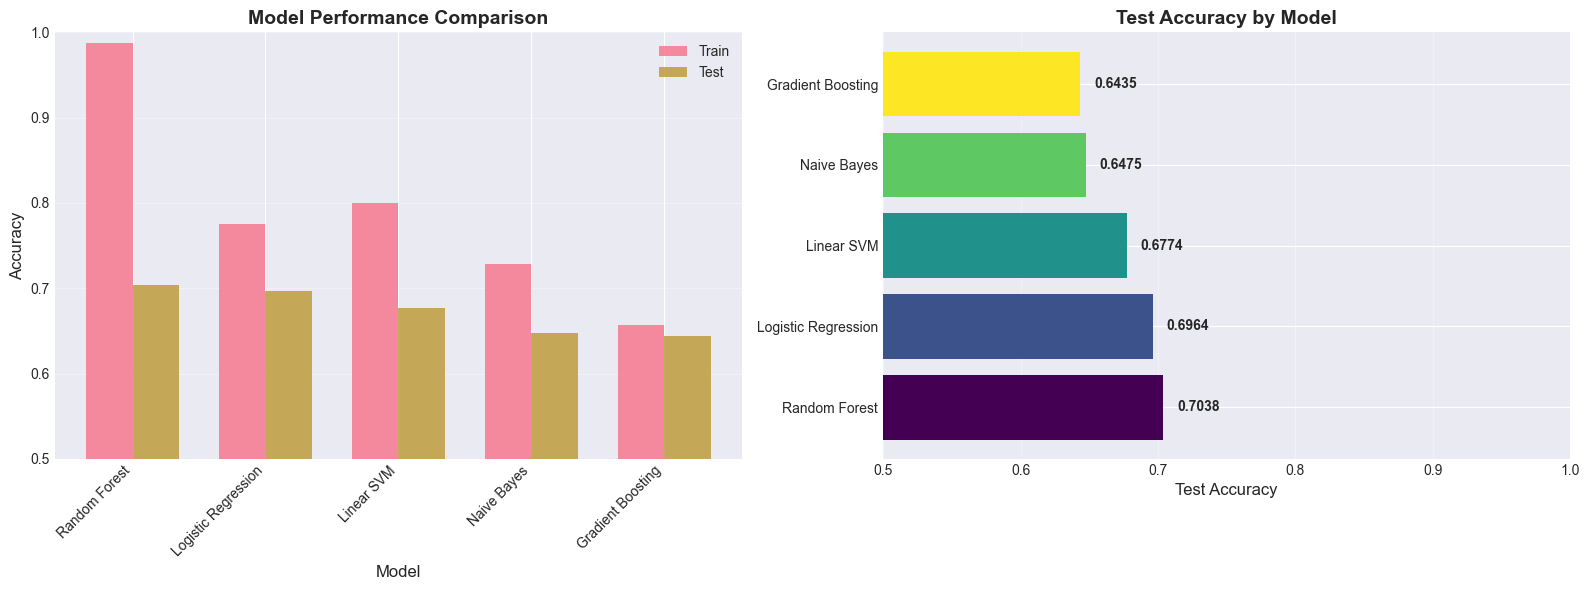

✓ Chart saved: charts/06_model_comparison.png


In [18]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train Accuracy'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Test accuracy only
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
axes[1].barh(comparison_df['Model'], comparison_df['Test Accuracy'], color=colors)
axes[1].set_xlabel('Test Accuracy', fontsize=12)
axes[1].set_title('Test Accuracy by Model', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0.5, 1.0])

# Add values on bars
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/06_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: charts/06_model_comparison.png")

In [19]:
# Detailed classification reports
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for name in results.keys():
    print(f"\n{name}:")
    print("-"*80)
    y_pred = results[name]['y_pred_test']
    print(classification_report(y_test, y_pred))
    
    # Save individual report
    with open(f'outputs/05_classification_report_{name.replace(" ", "_").lower()}.txt', 'w') as f:
        f.write(f"Classification Report: {name}\n")
        f.write("="*80 + "\n\n")
        f.write(classification_report(y_test, y_pred))

print("\n✓ Individual classification reports saved in outputs/")

DETAILED CLASSIFICATION REPORTS

Naive Bayes:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.72      0.53      0.61       999
     neutral       0.56      0.77      0.65      1416
    positive       0.77      0.59      0.67      1103

    accuracy                           0.65      3518
   macro avg       0.69      0.63      0.64      3518
weighted avg       0.68      0.65      0.65      3518


Logistic Regression:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.62      0.66       999
     neutral       0.63      0.74      0.68      1416
    positive       0.79      0.71      0.75      1103

    accuracy                           0.70      3518
   macro avg       0.71      0.69      0.70      3518
weighted avg       0.71      0.70      0.70      3518


Linear 

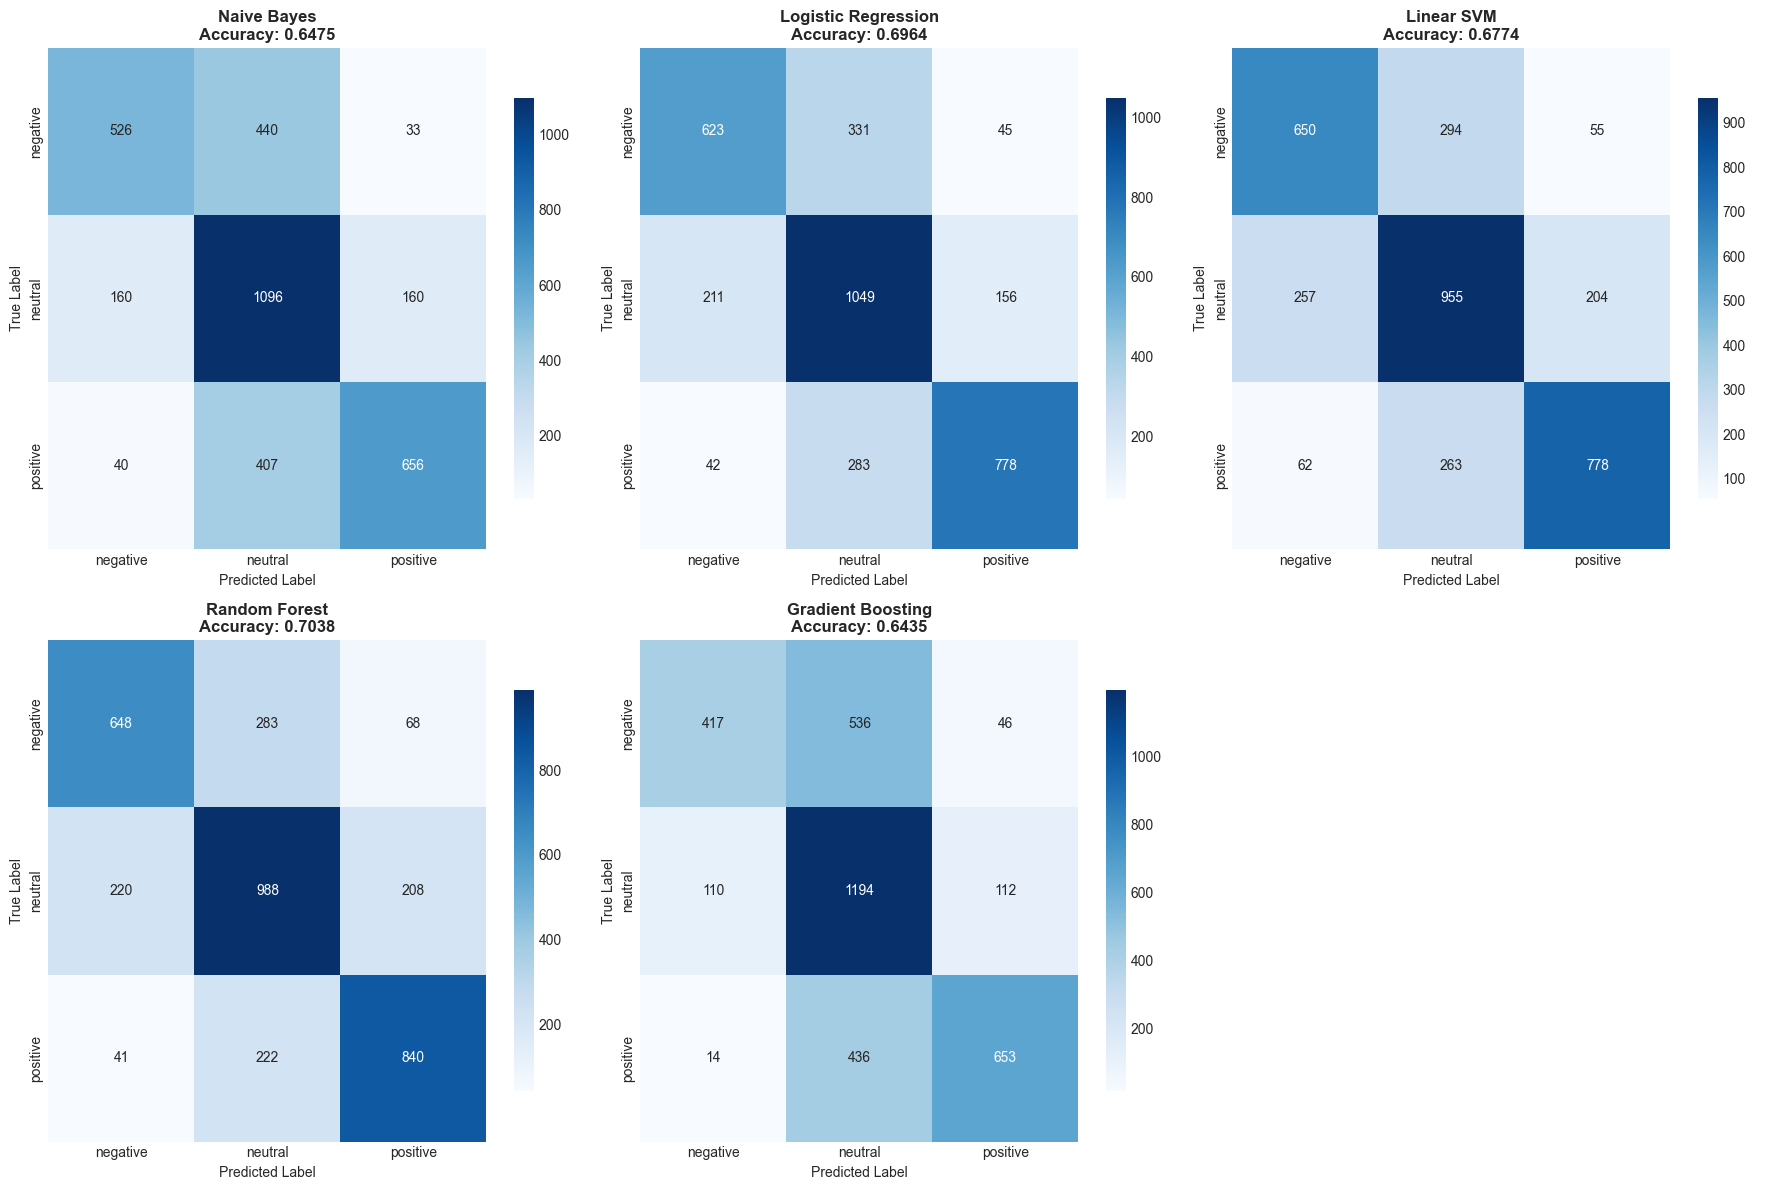

✓ Chart saved: charts/07_confusion_matrices.png


In [20]:
# Confusion matrices for all models
n_models = len(results)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    y_pred = result['y_pred_test']
    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'],
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{name}\nAccuracy: {result["test_accuracy"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

# Hide extra subplot
if n_models < 6:
    for idx in range(n_models, 6):
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('charts/07_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: charts/07_confusion_matrices.png")

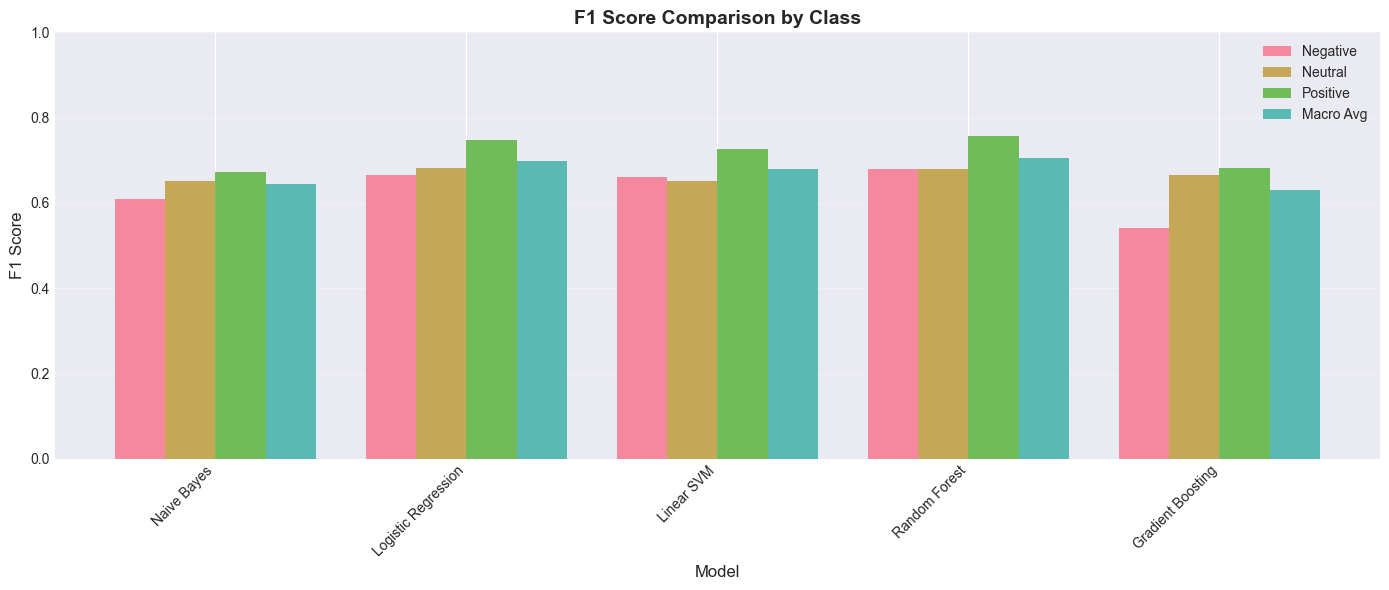

✓ Chart saved: charts/08_f1_scores.png
✓ F1 scores saved: outputs/06_f1_scores.csv


In [21]:
# F1 scores comparison by class
f1_data = []
for name in results.keys():
    report = results[name]['classification_report']
    f1_data.append({
        'Model': name,
        'Negative F1': report['negative']['f1-score'],
        'Neutral F1': report['neutral']['f1-score'],
        'Positive F1': report['positive']['f1-score'],
        'Macro Avg F1': report['macro avg']['f1-score']
    })

f1_df = pd.DataFrame(f1_data)

# Plot F1 scores
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(f1_df))
width = 0.2

ax.bar(x - 1.5*width, f1_df['Negative F1'], width, label='Negative', alpha=0.8)
ax.bar(x - 0.5*width, f1_df['Neutral F1'], width, label='Neutral', alpha=0.8)
ax.bar(x + 0.5*width, f1_df['Positive F1'], width, label='Positive', alpha=0.8)
ax.bar(x + 1.5*width, f1_df['Macro Avg F1'], width, label='Macro Avg', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score Comparison by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(f1_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('charts/08_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: charts/08_f1_scores.png")

# Save F1 scores
f1_df.to_csv('outputs/06_f1_scores.csv', index=False)
print("✓ F1 scores saved: outputs/06_f1_scores.csv")

## 8. Save Best Model and Artifacts

In [22]:
# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_accuracy = comparison_df.iloc[0]['Test Accuracy']

print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")

# Save best model
with open('artifacts/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save all models
for name, model in trained_models.items():
    filename = f'artifacts/{name.replace(" ", "_").lower()}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

print(f"\n✓ Best model saved: artifacts/best_model.pkl")
print(f"✓ All models saved in artifacts/")

BEST MODEL: Random Forest
Test Accuracy: 0.7038

✓ Best model saved: artifacts/best_model.pkl
✓ All models saved in artifacts/


In [23]:
# Save model metadata
metadata = {
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'num_features': X_train_tfidf.shape[1],
    'classes': list(y_train.unique()),
    'all_models_performance': {
        name: {
            'train_accuracy': float(results[name]['train_accuracy']),
            'test_accuracy': float(results[name]['test_accuracy'])
        }
        for name in results.keys()
    }
}

with open('artifacts/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✓ Model metadata saved: artifacts/model_metadata.json")

✓ Model metadata saved: artifacts/model_metadata.json


In [24]:
# Create prediction function for deployment
def predict_sentiment(text):
    """
    Predict sentiment of input text using the best model.
    
    Args:
        text (str): Input text to classify
    
    Returns:
        dict: Prediction results with sentiment and confidence
    """
    # Preprocess text
    clean = preprocess_text(text)
    
    # Vectorize
    features = tfidf_vectorizer.transform([clean])
    
    # Predict
    prediction = best_model.predict(features)[0]
    
    # Get probabilities if available
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(features)[0]
        confidence = max(probabilities)
    else:
        confidence = None
    
    return {
        'text': text,
        'sentiment': prediction,
        'confidence': confidence
    }

# Test prediction function
test_texts = [
    "I absolutely love this product! It's amazing!",
    "This is the worst experience ever. Very disappointed.",
    "The weather is nice today."
]

print("\nTEST PREDICTIONS")
print("="*80)
for text in test_texts:
    result = predict_sentiment(text)
    print(f"\nText: {result['text']}")
    print(f"Predicted Sentiment: {result['sentiment']}")
    if result['confidence']:
        print(f"Confidence: {result['confidence']:.4f}")

print("\n✓ Prediction function ready for deployment!")


TEST PREDICTIONS

Text: I absolutely love this product! It's amazing!
Predicted Sentiment: positive
Confidence: 0.9888

Text: This is the worst experience ever. Very disappointed.
Predicted Sentiment: negative
Confidence: 0.9900

Text: The weather is nice today.
Predicted Sentiment: positive
Confidence: 0.8996

✓ Prediction function ready for deployment!


## 9. Summary and Conclusions

In [25]:
# Generate final summary report
summary_report = f"""
{'='*80}
SENTIMENT ANALYSIS PROJECT - FINAL SUMMARY
{'='*80}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION:
{'-'*80}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Number of features: {X_train_tfidf.shape[1]:,}
- Classes: {list(y_train.unique())}

BEST MODEL:
{'-'*80}
- Model: {best_model_name}
- Test Accuracy: {best_accuracy:.4f}

ALL MODELS PERFORMANCE:
{'-'*80}
{comparison_df.to_string(index=False)}

OUTPUTS GENERATED:
{'-'*80}
Charts:
  - charts/01_sentiment_distribution.png
  - charts/02_text_length_analysis.png
  - charts/03_metadata_analysis.png
  - charts/04_wordclouds.png
  - charts/05_top_features.png
  - charts/06_model_comparison.png
  - charts/07_confusion_matrices.png
  - charts/08_f1_scores.png

Outputs:
  - outputs/01_data_overview.txt
  - outputs/02_eda_summary.json
  - outputs/03_preprocessing_examples.txt
  - outputs/04_model_comparison.csv
  - outputs/05_classification_report_*.txt (for each model)
  - outputs/06_f1_scores.csv

Artifacts:
  - artifacts/tfidf_vectorizer.pkl
  - artifacts/best_model.pkl
  - artifacts/*_model.pkl (all trained models)
  - artifacts/model_metadata.json

{'='*80}
PROJECT COMPLETED SUCCESSFULLY!
{'='*80}
"""

print(summary_report)

# Save summary report
with open('outputs/00_final_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Final summary saved: outputs/00_final_summary.txt")


SENTIMENT ANALYSIS PROJECT - FINAL SUMMARY

Date: 2026-01-02 13:46:10

DATASET INFORMATION:
--------------------------------------------------------------------------------
- Training samples: 27,384
- Test samples: 3,518
- Number of features: 5,000
- Classes: ['neutral', 'negative', 'positive']

BEST MODEL:
--------------------------------------------------------------------------------
- Model: Random Forest
- Test Accuracy: 0.7038

ALL MODELS PERFORMANCE:
--------------------------------------------------------------------------------
              Model  Train Accuracy  Test Accuracy
      Random Forest        0.988022       0.703809
Logistic Regression        0.774942       0.696418
         Linear SVM        0.799993       0.677374
        Naive Bayes        0.728856       0.647527
  Gradient Boosting        0.656515       0.643547

OUTPUTS GENERATED:
--------------------------------------------------------------------------------
Charts:
  - charts/01_sentiment_distribution.png